# Recommender with splitted user 

In [20]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


In [21]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [22]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [23]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

In [24]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [25]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [26]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [27]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

# Data pre-processing

In [28]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

In [29]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

recommender_alpha = P3alphaRecommender(URM_train)
recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)

recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
recommender_beta_ICM.URM_train = URM_train

hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha.W_sparse, recommender_beta_ICM.W_sparse)
hybridrecommender.fit(topK=200, alpha = 0.1)

P3alphaRecommender: URM Detected 33 (0.42 %) cold users.
P3alphaRecommender: URM Detected 1995 (7.68 %) cold items.
RP3betaRecommender: URM Detected 2 (0.01 %) cold users.
RP3betaRecommender: URM Detected 25 (0.10 %) cold items.
ItemKNNSimilarityHybridRecommender: URM Detected 33 (0.42 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 1995 (7.68 %) cold items.


In [30]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender_cold = UserKNNCFRecommender(URM_train)
recommender_cold.fit(shrink=100, topK=150, feature_weighting = "TF-IDF")

UserKNNCFRecommender: URM Detected 33 (0.42 %) cold users.
UserKNNCFRecommender: URM Detected 1995 (7.68 %) cold items.
Similarity column 7947 ( 100 % ), 13630.61 column/sec, elapsed time 0.01 min


In [31]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

recommender_item_cf = ItemKNNCFRecommender(URM_train)
recommender_item_cf.fit(shrink=600, topK=550, feature_weighting = "TF-IDF")

ItemKNNCFRecommender: URM Detected 33 (0.42 %) cold users.
ItemKNNCFRecommender: URM Detected 1995 (7.68 %) cold items.
Similarity column 25975 ( 100 % ), 5595.24 column/sec, elapsed time 0.08 min


In [32]:
recommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommeder_KNNItemCBF.fit(topK=100, shrink=400, feature_weighting = 'TF-IDF')

ItemKNNCBFRecommender: URM Detected 33 (0.42 %) cold users.
ItemKNNCBFRecommender: URM Detected 1995 (7.68 %) cold items.
Similarity column 25975 ( 100 % ), 3943.73 column/sec, elapsed time 0.11 min


In [33]:
from Base.NonPersonalizedRecommender import TopPop

recommender_top_popular = TopPop(URM_train)
recommender_top_popular.fit()

TopPopRecommender: URM Detected 33 (0.42 %) cold users.
TopPopRecommender: URM Detected 1995 (7.68 %) cold items.


In [34]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors = 825)

PureSVDRecommender: URM Detected 33 (0.42 %) cold users.
PureSVDRecommender: URM Detected 1995 (7.68 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


In [35]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

recommender_slim_bpr = SLIM_BPR_Cython(URM_all, recompile_cython=False)
recommender_slim_bpr.fit(epochs=200, batch_size=1000, sgd_mode='adagrad', learning_rate=0.001, positive_threshold_BPR=1, topK=400)

SLIM_BPR_Recommender: URM Detected 1079 (4.15 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.62 seconds. BPR loss is 5.12E-06. Sample per second: 12786
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.03 sec
Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 2.55E-05. Sample per second: 12105
SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 0.06 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 3.24E-05. Sample per second: 11593
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 0.09 sec
Processed 7947 ( 100.00% ) in 0.71 seconds. BPR loss is 4.91E-05. Sample per second: 11138
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.12 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 6.52E-05. Sample per second: 10660
SLIM_BPR_Recommender: Ep

In [36]:
# userei un CF per warm 
# CBF per i cold 

In [37]:
grouped_users = dataset.groupby(['row']).count()
grouped_users

,col,data
row,,
0,2,2
1,6,6
2,2,2
3,2,2
4,7,7
...,...,...
7942,5,5
7943,3,3
7944,156,156


In [38]:
sorted_users = grouped_users.sort_values(by=['col'], ascending=True)
sorted_users = sorted_users.index.to_numpy()
sorted_users

array([6012, 3608, 3171, ..., 1863, 2282, 7382], dtype=int64)

In [39]:
block_size = int(len(sorted_users)*0.10)
block_size

794

In [40]:

MAP_p3aplha_rp3beta_per_group = []
MAP_user_cf_cold_per_group = []
MAP_item_cf_cold_per_group = []
MAP_item_cbf_per_group = []
MAP_top_pop_per_group = []
MAP_pure_svd_per_group = []
MAP_slim_bpr_per_group = []
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(sorted_users))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)
    
    results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
    MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
    MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
    MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
    MAP_item_cbf_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
    MAP_top_pop_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_pure_svd)
    MAP_pure_svd_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_slim_bpr)
    MAP_slim_bpr_per_group.append(results[cutoff]["MAP"])

EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 201 ( 100.00% ) in 0.12 sec. Users per second: 1662
EvaluatorHoldout: Processed 201 ( 100.00% ) in 0.12 sec. Users per second: 1676
EvaluatorHoldout: Processed 201 ( 100.00% ) in 0.12 sec. Users per second: 1635
EvaluatorHoldout: Processed 201 ( 100.00% ) in 0.12 sec. Users per second: 1662
EvaluatorHoldout: Processed 201 ( 100.00% ) in 0.16 sec. Users per second: 1226
EvaluatorHoldout: Processed 201 ( 100.00% ) in 0.53 sec. Users per second: 381
EvaluatorHoldout: Processed 201 ( 100.00% ) in 0.12 sec. Users per second: 1662
EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 259 ( 100.00% ) in 0.15 sec. Users per second: 1672
EvaluatorHoldout: Processed 259 ( 100.00% ) in 0.17 sec. Users per second: 1552
EvaluatorHoldout: Processed 259 ( 100.00% ) in 0.15 sec. Users per second: 1694
EvaluatorHoldout: Processed 259 ( 100.00% ) in 0.17 sec. Users per second: 1561
EvaluatorHoldout: Processed 259 ( 100.00% ) i

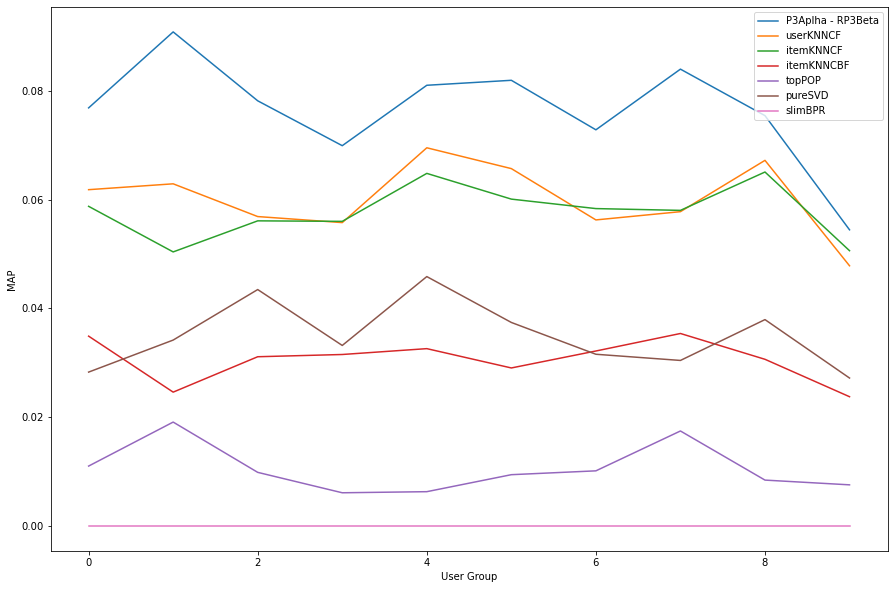

In [41]:
import matplotlib.pyplot as pyplot
%matplotlib inline  
pyplot.figure(figsize=(15,10))
pyplot.plot(MAP_p3aplha_rp3beta_per_group, label="P3Aplha - RP3Beta")
pyplot.plot(MAP_user_cf_cold_per_group, label="userKNNCF")
pyplot.plot(MAP_item_cf_cold_per_group, label="itemKNNCF")
pyplot.plot(MAP_item_cbf_per_group, label="itemKNNCBF")
pyplot.plot(MAP_top_pop_per_group, label="topPOP")
pyplot.plot(MAP_pure_svd_per_group, label="pureSVD")
pyplot.plot(MAP_slim_bpr_per_group, label="slimBPR")

pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

# Tuning a recommender only for small class 

In [44]:
group_id = 1
start_pos = group_id*block_size
end_pos = min((group_id+1)*block_size, len(sorted_users))
    
users_in_group = sorted_users[start_pos:end_pos]
    
users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
users_not_in_group = sorted_users[users_not_in_group_flag]
    
evaluator_itemCBF = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)

EvaluatorHoldout: Ignoring 7153 Users


In [45]:
from KNN.ItemKNNScoresHybridNRecommender import ItemKNNScoresHybridNRecommender
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_AsySVD_Cython


recommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommeder_KNNItemCBF.fit(topK=150, shrink=550, feature_weighting = 'TF-IDF', similarity='cosine')
recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors = 300)

#recommender_asy_svd = MatrixFactorization_AsySVD_Cython(URM_train)
#recommender_asy_svd.fit()
recommender_top_popular = TopPop(URM_train)
recommender_top_popular.fit()

recommender_list = [recommeder_KNNItemCBF, recommender_pure_svd, recommender_top_popular]
weights_list = [0.2,0.5,0.3]
hybridrecommender_1 = ItemKNNScoresHybridNRecommender(URM_train, recommender_list, number_of_recommenders = 3)
hybridrecommender_1.fit(weight_array = weights_list)


ItemKNNCBFRecommender: URM Detected 33 (0.42 %) cold users.
ItemKNNCBFRecommender: URM Detected 1995 (7.68 %) cold items.
Similarity column 25975 ( 100 % ), 3964.28 column/sec, elapsed time 0.11 min
PureSVDRecommender: URM Detected 33 (0.42 %) cold users.
PureSVDRecommender: URM Detected 1995 (7.68 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!
TopPopRecommender: URM Detected 33 (0.42 %) cold users.
TopPopRecommender: URM Detected 1995 (7.68 %) cold items.
ItemKNNScoresHybridMultipleRecommender: URM Detected 33 (0.42 %) cold users.
ItemKNNScoresHybridMultipleRecommender: URM Detected 1995 (7.68 %) cold items.
number of recommenders: 3


In [46]:
evaluator_itemCBF.evaluateRecommender(hybridrecommender_1)

entering cycle
entering cycle
entering cycle


NameError: name 'item_weights_1' is not defined

In [13]:
# tuning p3alpha + rp3 beta on worst classes

In [14]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.ItemKNNScoresHybridRecommender import ItemKNNScoresHybridRecommender


recommender_alpha = P3alphaRecommender(URM_train)
recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)

recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
recommender_beta_ICM.URM_train = URM_train

hybridrecommender = ItemKNNScoresHybridRecommender(URM_train, recommender_alpha, recommender_beta_ICM)
hybridrecommender.fit(alpha = 0.1)

P3alphaRecommender: URM Detected 55 (0.69 %) cold users.
P3alphaRecommender: URM Detected 1972 (7.59 %) cold items.


KeyboardInterrupt: 

In [ ]:
evaluator_itemCBF.evaluateRecommender(hybridrecommender)